## Redukcja wymiarowości przez zastosowanie PCA

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.decomposition import PCA
import datetime
# auto reolad zewnetrznych skryptow bez resetowania notebooka
import sys
sys.path.append('..')
import models
from utils.modeling_utils import SequenceGeneratorCV

%reload_ext autoreload
%autoreload 2

DEVICE = "cpu"

### określenie optymalnej liczby składowych

In [2]:
df = pd.read_csv('../../data/csv/six_cities.csv')
df['dt'] = pd.to_datetime(df['dt'])

df = df.reset_index(drop=True)

In [3]:
# wykorzystanie kodu z modeling_forecasting.ipynb

# na podstawie 96 godzin predykcja na dwa nastepne dni
input_width, output_width = 96, 48

# one moga zostac bez problemu jako stala czy cos, maja rozklady bardzo nienormalne
normalize_features = ['humidity', 'rain.1h', 'snow.1h', 'co', 'no', 'no2', 'so2', 'pm2_5', 'pm10', 'nh3']

# zmienne numeryczne ktore chcemy wykorzystac w modelu - póki co wszystkie (?)
numeric_features = ['day_sin', 'day_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos', 'temp', 'feels_like', 'pressure', 'humidity', 'wind.x', 'wind.y',\
                    'clouds.all', 'rain.1h', 'snow.1h', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']

# zmienne kategoryczne ktore chcemy wykorzystac w modelu
categorical_features = ['city', 'state']

# zmienne ktorych chcemy robic predykcje
output_columns = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']

seq_gen = SequenceGeneratorCV(
    numeric_features = numeric_features, 
    categorical_features = categorical_features,
    output_features = output_columns,
    normalize_features = normalize_features,
    device = DEVICE 
)
seq_gen.init_preprocessor(df[:10])
cities_dfs, cv_indices = seq_gen.split_data(df, 5, False)
for idx_train, idx_val in cv_indices:
    df_train = pd.concat([city.loc[idx_train, :] for city in cities_dfs], axis=0)
    df_val = pd.concat([city.loc[idx_val, :] for city in cities_dfs], axis=0)
    df_train = seq_gen.preprocessor.fit_transform(df_train)
    df_val = seq_gen.preprocessor.transform(df_val)
    break

In [4]:
# nie potrzebujemy zmiennej city
data_train = df_train.iloc[:, 1:]
data_val = df_val.iloc[:, 1:]

In [5]:
data_train.shape

(12992, 36)

In [6]:
data_train = data_train.reset_index(drop=True)

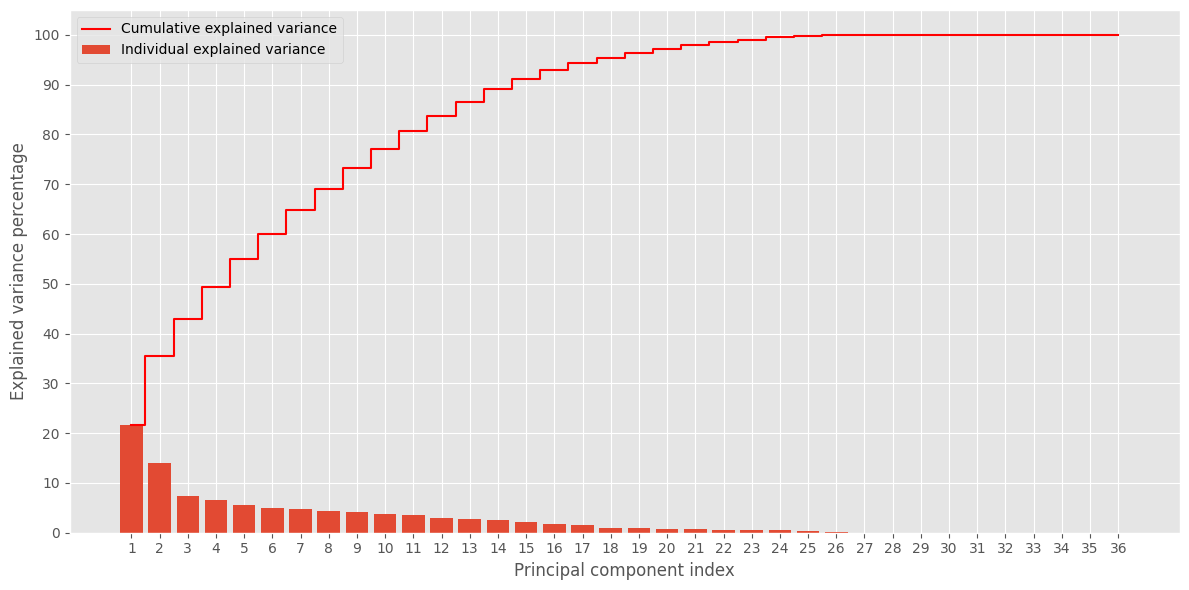

In [7]:
plt.figure(figsize = (12,6))

# wykres zależności wyjaśnionej wariancji od liczby składowych
pca = PCA(n_components=None)
pca.fit(data_train)

exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

#plt.subplot(4,2,count)   
plt.bar(range(1, 37), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, 37), cum_exp_var, where='mid',
        label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, 37)))
plt.yticks(ticks=list(range(0, 101, 10)))
plt.legend(loc='best')
plt.tight_layout()
plt.grid(True)

Na podstawie wykresu widzimy, że aby uwzględnić około 80% rozproszenia możemy wybrać 13 składowych.

### transformacja danych

In [8]:
pca = PCA(n_components = 13)
data_train_transformed = pca.fit_transform(data_train)
data_val_transformed = pca.fit_transform(data_val)

print('łączna wyjaśniona wariancja:', round(sum(pca.explained_variance_ratio_), 2))

łączna wyjaśniona wariancja: 0.87


In [9]:
data_train_transformed = pd.DataFrame(data_train_transformed)
data_val_transformed = pd.DataFrame(data_val_transformed)

In [10]:
data_train_transformed

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,7.478694,0.047039,-1.468068,0.303823,0.673856,0.144374,0.223207,-0.613400,1.308252,-0.422568,0.617478,-0.860065,1.733809
1,7.677827,-0.531324,-1.387746,0.625408,0.863480,0.378465,0.258277,-1.007841,1.136146,-0.365451,0.658747,-0.647565,2.270605
2,7.900483,-0.915670,-1.426804,0.388427,0.844475,0.026818,0.076689,-0.819892,1.299202,-0.281146,0.594783,-0.694378,1.660235
3,7.840817,-1.370413,-1.301974,0.320357,0.780438,-0.237860,0.029849,-0.830209,1.322604,-0.234968,0.593466,-0.695392,1.319488
4,7.436192,-1.612440,-1.289745,0.479172,0.670387,-0.420484,0.084452,-0.815600,1.326344,-0.174199,0.666916,-0.750985,1.231311
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12987,-0.237609,-0.363923,-2.285052,0.023993,2.343881,-0.331256,-0.578658,-0.034503,0.217723,0.816286,0.254342,-0.056114,0.221877
12988,-0.084469,-0.559468,-2.253068,-0.158252,2.287282,-0.784351,-0.753304,0.094533,0.237625,0.990329,0.166057,-0.249842,-0.122198
12989,-0.177621,-1.433602,-2.305249,0.132507,2.007936,-0.734106,-0.689386,-0.207615,0.020307,1.079992,0.275017,0.099797,0.421211
12990,-0.032880,-1.193688,-2.227693,-0.156181,1.922987,-1.369668,-0.875794,0.088245,0.077518,1.295020,0.119841,-0.297504,-0.114143


In [11]:
data_val_transformed

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.172135,-1.463987,-1.009714,-0.556967,1.091378,0.568719,-0.876930,1.896830,0.601225,-1.626338,0.646526,-0.573053,0.140496
1,0.171340,-1.487860,-0.854785,-0.677662,0.924597,0.776868,-0.741439,2.069620,0.763265,-1.734271,0.425080,-0.602571,0.170363
2,0.258059,-1.396175,-0.839928,-0.645800,0.757841,0.858948,-0.606340,2.183539,0.784690,-1.803911,0.316793,-0.606302,0.096271
3,0.553679,-1.144739,-0.904362,-0.360666,0.474095,0.768212,-0.531140,2.092165,0.591578,-1.784273,0.433906,-0.646952,-0.097079
4,1.487760,-0.856495,-0.557927,-0.213074,-0.476141,1.043231,-0.637886,2.317551,0.647210,-1.832381,0.277052,-0.387814,0.158439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12994,3.622684,-2.053484,-1.409010,0.353819,-1.126045,0.914265,0.847650,-0.897264,-0.604863,-1.092982,0.271120,-1.429269,0.820371
12995,3.945542,-2.181192,-1.234350,0.778443,-1.948947,0.584452,0.611790,-0.874686,-0.773750,-1.215472,0.503193,-1.212245,0.613463
12996,4.233135,-1.753174,-0.836298,0.529399,-1.950443,1.097388,0.530545,-0.731623,-0.684517,-1.019517,0.344099,-1.739224,0.331149
12997,4.024502,-0.914528,-0.547071,0.446061,-1.944703,1.279298,0.294166,-0.675706,-0.669851,-0.992879,0.150721,-1.676166,0.213047
